In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Root Bracketer to ensure optimum guesses for brentq calculation
def rootBracketing(f, a = 0.01, b = 10**10, maxIter = 7000, factor = 0.7):
    for k in range(maxIter):
        if f(a) * f(b) < 0:
            return (a, b)
        if abs(f(a)) < abs(f(b)):
            a += factor * (a-b) # if f(a) is closer to 0, change a
        else:
            b += factor * (b-a) # if f(b) is closer to 0, change b
    return (a, b)

In [3]:
#Converts the Tenor provided in excel file to integer values
def tenor(df):
    int_tenor = []
    for i in df["Tenor"]:
        integer = int(i[ :-1])
        int_tenor.append(integer)
    int_tenor[0] = 0.5
    return int_tenor

In [4]:
#Extract & Clean excel file sheets.
def df_parser(name = 'IR Data.xlsx'):
    df = pd.read_excel(name, sheet_name = ["IRS","OIS","Swaption"])
    IRS = df["IRS"].dropna(thresh=len(df["IRS"]) - 2, axis=1)
    IRS['Tenor'] = tenor(IRS)
    OIS = df["OIS"].dropna(thresh=len(df["OIS"]) - 2, axis=1)
    OIS['Tenor'] = tenor(OIS)
    Swaption = df["Swaption"]
    Swaption.columns = df["Swaption"].iloc[1, : ]
    Swaption = df['Swaption'].iloc[2: ].reset_index(drop=True)
    return IRS,OIS,Swaption

In [5]:
IRS,OIS,Swaption = df_parser()

In [6]:
def f_and_libor(current_disc, prev_disc, days):
    f = ((1/(current_disc/prev_disc))**(1/days) - 1) * 360
    L = (1+f/360)**360 - 1
    return f, L

In [7]:
def OISD(df):
    special = (df[df["Tenor"] <= 1])
    a , b = 0.01, 10**10
    function = lambda x: x * (special["Tenor"][0] * special["Rate"][0] + 1) - 1
    ar,br = rootBracketing(function,a,b, 0, 10)
    D_0_6m = brentq(function, ar, br)
    f_0, L_0_6m = ((1/(D_0_6m))**(1/180) - 1) * 360, 1/D_0_6m - 1 #f(0,6m) and L(0,6m)
    function = lambda x: (1 + special["Rate"][1]) * x - 1
    ar,br = rootBracketing(function,a,b, 0, 10)
    D_0_1y = brentq(function, ar, br)
    f_1, L_6m_12m = ((1/(D_0_1y/D_0_6m))**(1/180) - 1) * 360, 1/D_0_6m * 1/(D_0_1y/D_0_6m) - 1 #f(6m,12m) and L(6m,12m)
    D_list, f_list, L_list = [D_0_6m,D_0_1y], [f_0, f_1], [L_0_6m,L_6m_12m]
    for i in range(2,len(df)):
        if df["Tenor"][i] - df["Tenor"][i-1] <= 1: 
            function = lambda x: (1 + df["Rate"][i]) * x - D_list[-1] + (np.array(D_list[1: ]) * df["Rate"][i]).sum() - (np.array(L_list[1: ]) * np.array(D_list[1: ])).sum()
            ar,br = rootBracketing(function, a, b, 10, 0.8)
            result = brentq(function, ar,br)
            D_list.append(result)
            f, L = f_and_libor(D_list[-1],D_list[-2], 360)
            f_list.append(f)
            L_list.append(L)
        else:
            middle = []
            interpolated_range = ((df["Tenor"][i] - df["Tenor"][i-1]))
            constant = ((df["Tenor"][i] - df["Tenor"][i-1]) + 1)/2
            function = lambda x: (constant * df["Rate"][i] + 1) * x - D_list[-1] + (df["Rate"][i] * constant * D_list[-1]) + \
            (df["Rate"][i] * np.array(D_list[1:-1])).sum() -  (np.array(L_list[1: ]) * np.array(D_list[1: ])).sum() 
            ar,br = rootBracketing(function, a, b, 10, 0.8)
            result = brentq(function, ar,br)
            for y in range(1, int(interpolated_range)):
                points = (y/interpolated_range * result) + ((interpolated_range - y)/interpolated_range * D_list[-1])
                middle.append(points)
            middle.append(result)
            for discounts in range(len(middle)):
                D_list.append(middle[discounts])
                f, L = f_and_libor(D_list[-1],D_list[-2], 360)
                f_list.append(f)
                L_list.append(L)
    return D_list, f_list, L_list

In [8]:
df, f, libor = OISD(OIS)
Odisc = pd.concat([pd.Series(df), pd.Series(f), pd.Series(libor)], axis = 1)
Odisc.reset_index(inplace = True)
Odisc.columns = ["Tenor", "Discount", "f", "Libor"]
Odisc["Tenor"][0] = 0.5
Odisc.to_pickle('Odisc')
Odisc

,Tenor,Discount,f,Libor
0,0.5,0.998752,0.002498,0.001250
1,1.0,0.997009,0.003493,0.003000
2,2.0,0.993531,0.003495,0.003501
3,3.0,0.990015,0.003545,0.003551
4,4.0,0.986117,0.003946,0.003953
5,5.0,0.982184,0.003996,0.004004
6,6.0,0.977295,0.004990,0.005003
7,7.0,0.972406,0.005015,0.005028
8,8.0,0.966929,0.005648,0.005664
9,9.0,0.961453,0.005680,0.005696


In [9]:
def interpolator(data, freq = 0.5, second_freq = 0.25):
    for i in range(1,len(data)):
        if data["Tenor"][i] - data["Tenor"][i-1] != freq:
            interpolated_disc = (data["Discount"][i] + data["Discount"][i-1])/2
            interpolated_years = (data["Tenor"][i] + data["Tenor"][i-1])/2
            data.loc[interpolated_years] = [interpolated_years, interpolated_disc]
        else:
            pass
    data = data.sort_index().reset_index(drop = True)
    semi_annually = data.copy()
    if second_freq == 0.25:
        for i in range(1,len(data)):
            interpolated_disc = (data["Discount"][i] + data["Discount"][i-1])/2
            interpolated_years = (data["Tenor"][i] + data["Tenor"][i-1])/2
            data.loc[interpolated_years] = [interpolated_years, interpolated_disc]
        data.loc[0.25] = [0.25, (1 + data["Discount"][0])/2]
        data = data.sort_values(by = "Tenor").reset_index(drop = True)
    quarterly = data.copy()
    return semi_annually, quarterly

In [10]:
O_semi_annually, O_quarterly = interpolator(Odisc.iloc[ : , : 2], 0.5, 0.25)

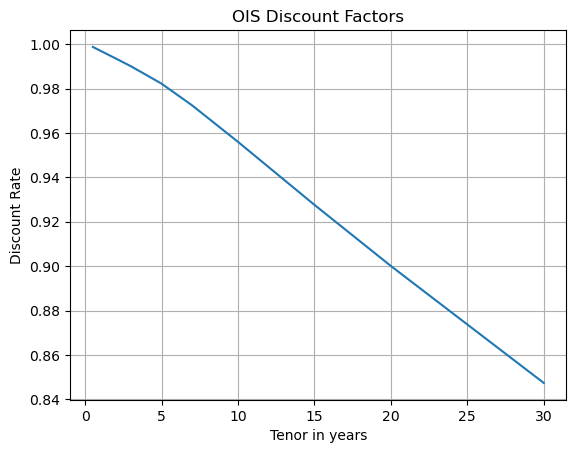

In [11]:
plt.plot(Odisc['Tenor'],Odisc['Discount'])
plt.xlabel('Tenor in years')
plt.ylabel('Discount Rate')
plt.title('OIS Discount Factors')
plt.grid()

In [12]:
def fwdbor(current_disc, prev_disc, freq = 0.5):
    return ((1/freq)*(prev_disc - current_disc)/current_disc)

In [13]:
def LIBOR(rate,OIS):
    a, b, dbor, libor = 1e-5, 10**10, [], []
    d6m = 1/(1 + 0.5 * rate["Rate"][0])
    dbor.append(d6m)
    l6m = (1 - d6m)/(d6m * 0.5)
    libor.append(l6m)
    l1 = ((rate["Rate"][1] * OIS["Discount"][ :2]).sum() - (OIS["Discount"][0] * l6m))/OIS["Discount"][1]
    d1 = d6m/(1+ l1 * 0.5)
    libor.append(l1)
    dbor.append(d1)
    #iterate over the generic formula to calculate D(0,1.5y) - D(0,30y)
    for i in range(2,len(rate)):
        Range = int(rate['Tenor'][i] * 2)
        gap = 2
        left = dbor[-1] 
        distance = int(rate['Tenor'][i] - rate['Tenor'][i-1])
        if distance == 1:
            f = lambda D: (((OIS['Discount'][:Range-gap]*libor[:Range-gap]).sum()\
                                 + OIS['Discount'][Range-2] * 2 * ((2*left)/(left+D)-1)\
                                 + OIS['Discount'][Range-1] * 2 * (0.5 * (left+D)/(D)-1)) -\
                                sum(OIS['Discount'][:Range] *rate['Rate'][i]))
            ar, br = rootBracketing(f, a, b)
            right = brentq(f,ar,br)
            middle = (right+left)/2
            dbor.append(middle)
            libor.append(fwdbor(dbor[-1], dbor[-2]))
            dbor.append(right)
            libor.append(fwdbor(dbor[-1], dbor[-2]))
        if distance > 1:
            gap, middle = distance * 2, ''
            left = dbor[-1]
            OISd = OIS['Discount'][Range-gap]
            middle += f'2*({OISd}*(({left})'
            for u in range(1,gap):
                OISdu = OIS['Discount'][Range-gap+u]
                middle+= f'/(D*{u}/{gap} + {left}*({gap}-{u})/{gap})-1)'
                middle+= f'+ {OISdu}*((D*{u}/{gap} + {left}*({gap}-{u})/{gap})'
            middle += '/D - 1))'
            f = lambda D: (((OIS['Discount'][:Range-gap]*libor[:Range-gap]).sum() \
                              + eval(middle)) - (OIS['Discount'][:Range] *rate['Rate'][i]).sum())
            ar, br = rootBracketing(f, a, b)
            right = brentq(f,ar,br)
            for j in range(1,gap):
                middles = j/gap*right + (gap-j)/(gap)*left
                dbor.append(middles)
                new_libor = fwdbor(dbor[-1], dbor[-2])
                libor.append(new_libor)
            dbor.append(right)
            libor.append(fwdbor(dbor[-1], dbor[-2]))
    df = pd.DataFrame({'Tenor':np.linspace(0.5,30,60),'Discount':dbor,'Libor':libor})
    return df

In [14]:
Ldisc = LIBOR(IRS,O_semi_annually)
Ldisc.to_pickle('Ldisc')
Ldisc

,Tenor,Discount,Libor
0,0.5,0.987654,0.025000
1,1.0,0.972577,0.031005
2,1.5,0.957378,0.031751
3,2.0,0.942179,0.032263
4,2.5,0.926330,0.034218
5,3.0,0.910482,0.034814
6,3.5,0.894731,0.035207
7,4.0,0.878981,0.035838
8,4.5,0.863985,0.034713
9,5.0,0.848989,0.035326


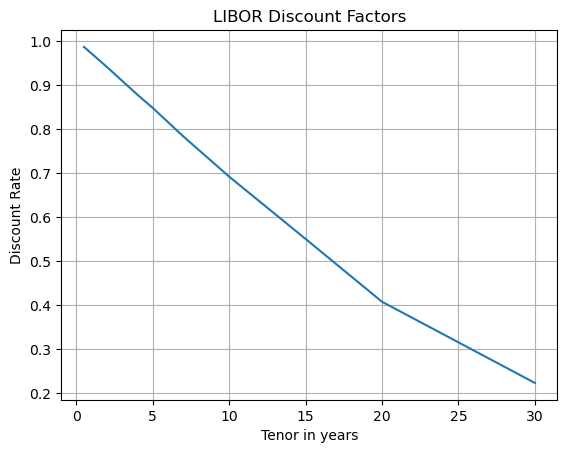

In [15]:
plt.plot(Ldisc['Tenor'],Ldisc['Discount'])
plt.xlabel('Tenor in years')
plt.ylabel('Discount Rate')
plt.title('LIBOR Discount Factors')
plt.grid()

In [16]:
L_semi_annually,L_quarterly =interpolator(Ldisc.iloc[ : , :2].copy(), 0.5, 0.25)
L_quarterly["Libor"] = [None] * len(L_quarterly)
L_quarterly["Libor"][0] = (1/0.25) * (1 - L_quarterly["Discount"][0])/L_quarterly["Discount"][0]
for i in range(1,len(L_quarterly)):
    L_quarterly["Libor"][i] = fwdbor(L_quarterly["Discount"][i], L_quarterly["Discount"][i-1], 0.25)
L_quarterly

,Tenor,Discount,Libor
0,0.25,0.993827,0.024845
1,0.50,0.987654,0.025
2,0.75,0.980116,0.030767
3,1.00,0.972577,0.031005
4,1.25,0.964977,0.031501
...,...,...,...
115,29.00,0.242118,0.076225
116,29.25,0.237504,0.077706
117,29.50,0.232890,0.079246
118,29.75,0.228276,0.080847


In [17]:
def PV01(Odisc, t, T, freq = 2):
    expiry = int((t*freq))
    tenor = int((t+T)*freq)
    if t == 0:
        expiry = 1
        tenor = int(T*freq + 1)
    return (1/freq)*(Odisc['Discount'][expiry:tenor]).sum()

def fwd_swap(Ldisc, Odisc, t, T, freq = 2):
    expiry = int((t*freq))
    tenor = int((t+T)*freq)
    if t == 0:
        expiry = 1
        tenor = int(T*freq + 1)
    numerator = (1/freq)*(Odisc['Discount'][expiry:tenor]*Ldisc['Libor'][expiry:tenor]).sum()
    denominator = PV01(Odisc, t, T)
    return numerator/denominator

In [18]:
def fwd_df(Ldisc, Odisc, freq = 2):
    FSA = [(1,1),(1,2),(1,3),(1,5),(1,10),\
          (5,1),(5,2),(5,3),(5,5),(5,10),\
          (10,1),(10,2),(10,3),(10,5),(10,10)]
    FSAdf, Tenor, Expiry = [],[],[]
    for i in range(len(FSA)):
        FSAdf.append(fwd_swap(Ldisc, Odisc,FSA[i][0],FSA[i][1],freq))
        Tenor.append(FSA[i][1])
        Expiry.append(FSA[i][0])
    FSAdf = pd.DataFrame({'Expiry':Expiry,'Tenor':Tenor,'FSR':FSAdf})
    return FSAdf

In [19]:
FSR = fwd_df(Ldisc, O_semi_annually)
FSR.to_pickle('FSR')
FSR

,Expiry,Tenor,FSR
0,1,1,0.032007
1,1,2,0.033259
2,1,3,0.034011
3,1,5,0.035255
4,1,10,0.038428
5,5,1,0.039274
6,5,2,0.040075
7,5,3,0.040072
8,5,5,0.041093
9,5,10,0.043634
